<a href="https://colab.research.google.com/github/sashunny/supersickrobot/blob/main/RobotOnRails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import keras
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from keras.optimizers import RMSprop, Nadam

np.random.seed(1)

In [2]:
# mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# unzip dataset
!unzip -uq "/content/drive/My Drive/dataset.zip" -d "/content/drive/My Drive/dataset"

In [4]:
# define train and test paths
train_path = '/content/drive/My Drive/dataset/train_original'
test_path = '/content/drive/My Drive/dataset/test_original'

Train Label file shape:-
(224, 3)
Length of image filename:-
224


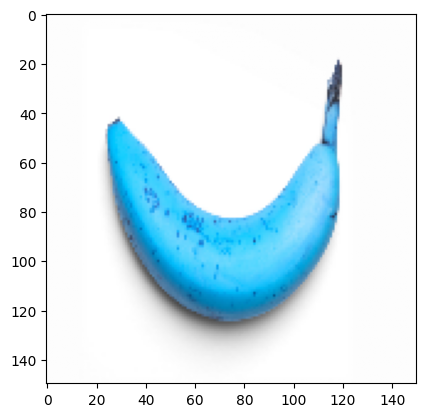

In [5]:
## Parse XML file, create train labels and save image file names

image_filename = []
train_labels = []
shape = (150,150) #model input shape

for filename in os.listdir('/content/drive/My Drive/dataset/train_original'):
  # read XML files
  if filename.split('.')[1] == 'xml':
    # append the filenames in a list
    image_filename.append(filename.split('.')[0])
    q = [0,0,0]
    temp = []
    # parse the XML
    tree = ET.parse(os.path.join(train_path,filename))
    root = tree.getroot()
    # get the object names (classes) 
    for objects in root.iter('name'):
      temp.append(objects.text)

    temp = list(set(temp)) #remove duplicates

    # one-hot encoding
    for obj in temp:
      if obj == "apple":
        q[0] = 1
      elif obj == "banana":
        q[1] = 1
      elif obj == "orange":
        q[2] = 1

    train_labels.append(q)

# convert the list in a np array
train_labels = np.array(train_labels)
print("Train Label file shape:-")
print(train_labels.shape)
print("Length of image filename:-")
print(len(image_filename))

# load the images and create train_images numpy array
train_images = []
for imgName in image_filename:
  name = imgName + '.jpg'
  img = cv2.imread(os.path.join(train_path,name))
  img = cv2.resize(img,shape)
  train_images.append(img)


train_images = np.array(train_images)
# normalize 
train_images = train_images/255
plt.imshow(train_images[0])


In [6]:
# Split into train and validation dataset
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,random_state=42)
print("Train Images: " + str(x_train.shape[0]))

print("Validation Images: " + str(x_val.shape[0]))


Train Images: 168
Validation Images: 56


In [8]:
## Transfer learning

# Inception V3

from keras.applications.inception_v3 import InceptionV3

base = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in base.layers:
    layer.trainable = False


x = Flatten()(base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation='sigmoid')(x)

model = Model(base.input, x)

#model.compile(optimizer = Nadam(lr=0.001) , loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=0.001), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
model.compile(optimizer = RMSprop(lr=0.001) , loss = 'binary_crossentropy', metrics = ['accuracy'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2)

it = datagen.flow(x_train, y_train)

In [10]:
# Train the model

#Fit = model.fit(x_train,y_train,epochs=10,batch_size=60,validation_data=(x_val,y_val))
Fit_augmen = model.fit_generator(it, epochs=10, steps_per_epoch= 3, validation_data=(x_val,y_val))


<ipython-input-10-967bc2e79f2c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_augmen = model.fit_generator(it, epochs=10, steps_per_epoch= 3, validation_data=(x_val,y_val))


Epoch 1/10
3/3 [==============================] - 10s 1s/step - loss: 65.0496 - accuracy: 0.4688 - val_loss: 18.0606 - val_accuracy: 0.5357
Epoch 2/10
3/3 [==============================] - 1s 157ms/step - loss: 21.2222 - accuracy: 0.4167 - val_loss: 6.8972 - val_accuracy: 0.7500
Epoch 3/10
3/3 [==============================] - 1s 204ms/step - loss: 7.9542 - accuracy: 0.7188 - val_loss: 8.7316 - val_accuracy: 0.6071
Epoch 4/10
3/3 [==============================] - 1s 297ms/step - loss: 5.4352 - accuracy: 0.7083 - val_loss: 3.1618 - val_accuracy: 0.7857
Epoch 5/10
3/3 [==============================] - 1s 365ms/step - loss: 3.1759 - accuracy: 0.7708 - val_loss: 2.7935 - val_accuracy: 0.8036
Epoch 6/10
3/3 [==============================] - 1s 372ms/step - loss: 1.7783 - accuracy: 0.8333 - val_loss: 3.2449 - val_accuracy: 0.7500
Epoch 7/10
3/3 [==============================] - 1s 190ms/step - loss: 3.7182 - accuracy: 0.7361 - val_loss: 0.8820 - val_accuracy: 0.8929
Epoch 8/10
3/3 [===

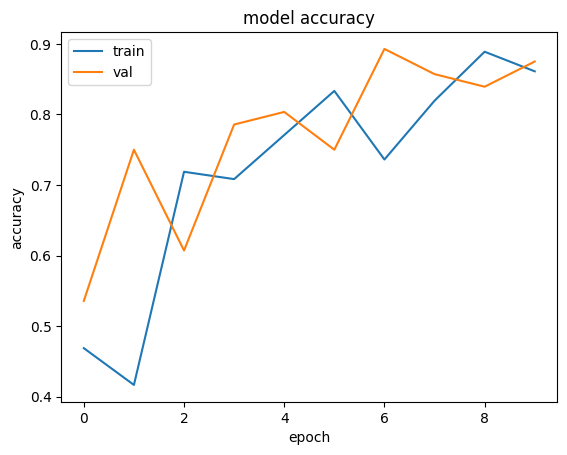

In [11]:
plt.plot(Fit_augmen.history['accuracy'])
plt.plot(Fit_augmen.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# fine tuning the model

for layer in base.layers:
    layer.trainable = True

model.compile(optimizer = RMSprop(lr=0.00001), loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
#model.summary()

In [14]:
#x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,random_state=1)
#Fit_finetuned = model.fit(x_train,y_train,epochs=4,batch_size=60,validation_data=(x_val,y_val))
Fit_finetuned = model.fit_generator(it, epochs=3, steps_per_epoch= 3, validation_data=(x_val,y_val))

Epoch 1/3


<ipython-input-14-2f9714db3c07>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_finetuned = model.fit_generator(it, epochs=3, steps_per_epoch= 3, validation_data=(x_val,y_val))


3/3 [==============================] - 19s 2s/step - loss: 1.3253 - accuracy: 0.5417 - val_loss: 1.4101 - val_accuracy: 0.8571
Epoch 2/3
3/3 [==============================] - 1s 199ms/step - loss: 1.3742 - accuracy: 0.5972 - val_loss: 1.3084 - val_accuracy: 0.8571
Epoch 3/3
3/3 [==============================] - 1s 238ms/step - loss: 1.0635 - accuracy: 0.6458 - val_loss: 1.2208 - val_accuracy: 0.8750


/content/drive/My Drive/dataset/test_original/banana_8.jpg
1/1 [==============================] - 0s 39ms/step
banana (1.0)
apple (0.000538)
orange (1.48e-25)


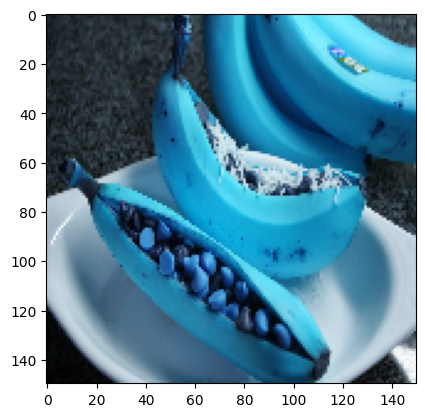

In [17]:
# model testing

## load an image from the test data and test the model

test_image_name = 'banana_8.jpg'
test_img = cv2.imread(os.path.join(test_path,test_image_name))
print(os.path.join(test_path,test_image_name))
test_img = cv2.resize(test_img,shape)
test_image = []
test_image.append(test_img)
test_image = np.array(test_image)
test_image = test_image/255
plt.imshow(test_image[0])
classes = np.array(["apple", "banana", "orange"])

prediction = model.predict(test_image) 
top_3 = np.argsort(prediction[0])[:-4:-1]


for i in range(3):
  print("{}".format(classes[top_3[i]])+" ({:.3})".format(prediction[0][top_3[i]]))


In [18]:
#model.save('/content/drive/My Drive/model/ROR_model_inception_1')

In [19]:
#model1 = keras.models.load_model('/content/drive/My Drive/model/ROR_model_inception_1')